In [191]:
#uncomment if you don't have the packages installed
#!pip install pyLDAvis 
#!pip install openai
#!pip install tqdm
#!pip install python-docx
import openai

openai.api_key = '<input your api key>'

In [192]:
#import variables from preprocessing
%store -r token_df
%store -r lemmatized_documents
%store -r wtn_txt
%store -r articles

### We will start with topic modeling. Topic modeling uncovers main topics in our documents. We will use LDA for this.
### Coherence tests coherence of our model. This metod should be interpreted very subjectivly, but we still created a gridsearch for it.

In [193]:
from gensim import corpora, models

def grid_search_lda(list_of_tokens, nt, np):

    """
    Perform a grid search over the number of topics (nt) and the number of passes (np) for the LDA model, 
    to find the model with the best coherence score.

    Parameters:
    list_of_tokens : list
        A list of tokenized documents, where each document is a list of its tokens.
    nt : list
        A list of integers representing the number of topics that the LDA model should consider.
    np : list
        A list of integers representing the number of passes (epochs) over the corpus during training.

    Returns:
    out : list
        A list of lists, each containing the number of topics, the number of passes, and the coherence score for a model.
    best_score : float
        The highest coherence score found during the grid search.
    best_model : gensim.models.LdaModel
        The LDA model with the highest coherence score.
        
    Example:
    out, best_score, best_model = grid_search_lda(list_of_tokens, [3, 5, 10], [1, 10, 20])
    """
    
    # Create a dictionary from the documents
    dictionary = corpora.Dictionary(list_of_tokens)

    # Convert document into the bag-of-words (BoW) format = list of (token_id, token_count) tuples.
    corpus = [dictionary.doc2bow(doc) for doc in list_of_tokens]
    
    out = []
    best_score = -15
    best_model = None
    for t in nt:
        for p in np:
            # Create a LDA model
            lda_model = models.LdaMulticore(corpus, num_topics=t, id2word=dictionary, passes=p)
            #get coherence 
            coherence_model_lda = CoherenceModel(model=lda_model, texts=list_of_tokens, dictionary=dictionary, coherence='u_mass')
            coherence_lda = coherence_model_lda.get_coherence()
            
            # Print the topics
            topics = lda_model.print_topics()
            out.append([t, p,coherence_lda])
            if coherence_lda > best_score:
                best_score = coherence_lda
                best_model = lda_model
    return out, best_score, best_model

In [194]:
i, bs, bm = grid_search_lda(lemmatized_documents,[5,6],[50,100,200])
print(i)
print(bs)
print(bm)

[[5, 50, -0.566165896619729], [5, 100, -0.6079689782171678], [5, 200, -0.7431501858480765], [6, 50, -0.6408529036847812], [6, 100, -0.846869691888561], [6, 200, -0.6525748153432731]]
-0.566165896619729
LdaModel(num_terms=24618, num_topics=5, decay=0.5, chunksize=2000)


### Let's use some vizualization for LDA

In [195]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
from joblib import parallel_backend


dictionary = corpora.Dictionary(lemmatized_documents)
corpus = [dictionary.doc2bow(text) for text in lemmatized_documents]

lda_model = models.LdaModel(corpus, num_topics=5, id2word=dictionary, passes=100)

# Unfortunatly i had issues with the parallel threding hence the workaround using parallel_backend
with parallel_backend('threading', n_jobs=1):
    vis_data = gensimvis.prepare(lda_model, corpus, dictionary, sort_topics=False, mds='mmds')
pyLDAvis.display(vis_data)



### Enterpreting the outcome of the LDA vizualization
### On the left panel we can se Intertopic Distance Map - this map shows us how similar the topics are (distance between the center of circles) and how prevelant are the topics in the corpus (size of the circle)
### The right panel shows us most revelant terms for the topics on the left. We can adjust it using the λ metric.

### Now let's do some sentiment analysis. We would like to check the poarity, but we have to keep in mind that our dataset is made out of very technical news in the field on AI. This means that we might face some challenges using general pourpouse sentiment analysis tools.

In [196]:
# First we will start with very simple lexicon based analysis
from textblob import TextBlob

sentiment = []
for txt in wtn_txt:
    # Create a TextBlob object
    blob = TextBlob(txt)
    sentiment.append(blob.sentiment)


In [197]:
print(sentiment[0])

Sentiment(polarity=0.129457843743558, subjectivity=0.4723860691462732)


In [198]:
#let's unpack the tuple
sent = []
for s in sentiment:
    sent.append([s.polarity,s.subjectivity])
print(sent[0])

[0.129457843743558, 0.4723860691462732]


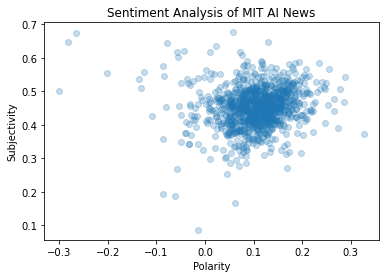

In [199]:
#let's vizualize it 
import matplotlib.pyplot as plt

polarity = [item[0] for item in sent]
subjectivity = [item[1] for item in sent]

# Create the scatter plot
plt.scatter(polarity, subjectivity, alpha=0.25)

# Add labels for clarity
plt.title('Sentiment Analysis of MIT AI News')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

# Display the plot
plt.show()

### Named Entity Recognition (NER) is process of detecting entities in the text. This means that words like: Croatia, Poland, Apple, Microsoft, Lex Fridman will be detected.

In [202]:
nlp = spacy.load('en_core_web_sm')

# Processing the text
doc = nlp(df['Text'][0])

# Printing named entities
for ent in doc.ents:
    print(ent.text, ent.label_)


Maverick PERSON
Tom Cruise PERSON
Maverick PERSON
AI ORG
MIT ORG
Maverick GPE
Chuchu Fan PERSON
Wilson ORG
Aeronautics and Astronautics ORG
the Laboratory for Information and Decision Systems ORG
Oswin So PERSON
the Robotics: Science and Systems FAC
two CARDINAL
MIT ORG
two CARDINAL
First ORDINAL
second ORDINAL
second ORDINAL
2018 DATE
Fan PERSON
MIT ORG
first ORDINAL
Professor Fan’s WORK_OF_ART
Stanley Bak PERSON
the Department of Computer Science at Stony Brook University ORG
17 CARDINAL
the Air Force Research Lab ORG
MIT Lincoln Laboratory ORG
the Safety in Aerobatic Flight Regimes ORG


### TF-IDF stands for Term Frequency-Inverse Document Frequency. It is a statistical measure used to evaluate the importance of a word in a document. We will take 10 articles and present them using WordClouds.

        100   1000000  1000000000  abhishek   ability      able  academia  \
0  0.000000  0.000000    0.000000  0.000000  0.000000  0.052169  0.000000   
1  0.000000  0.000000    0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.000000  0.000000    0.000000  0.000000  0.013451  0.011123  0.000000   
3  0.000000  0.023017    0.019566  0.000000  0.024712  0.010217  0.000000   
4  0.000000  0.000000    0.024475  0.000000  0.030911  0.000000  0.000000   
5  0.026539  0.000000    0.000000  0.000000  0.014247  0.011781  0.026539   
6  0.000000  0.000000    0.000000  0.000000  0.012325  0.010191  0.000000   
7  0.000000  0.000000    0.000000  0.000000  0.000000  0.053972  0.000000   
8  0.000000  0.000000    0.000000  0.000000  0.000000  0.011239  0.000000   
9  0.000000  0.000000    0.000000  0.024663  0.013240  0.010948  0.000000   

   academic   academy  accelerate  ...  yanomami      year       yet  \
0  0.000000  0.000000    0.000000  ...  0.000000  0.000000  0.000000   
1  0.000

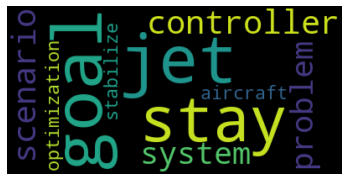

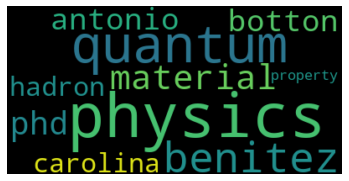

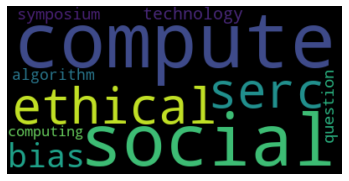

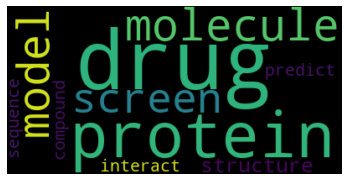

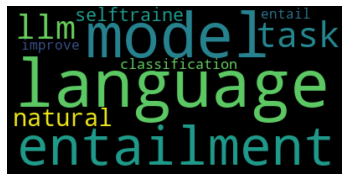

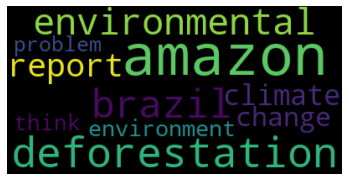

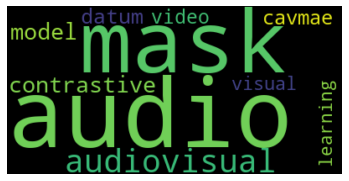

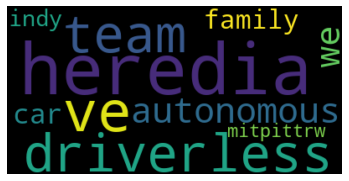

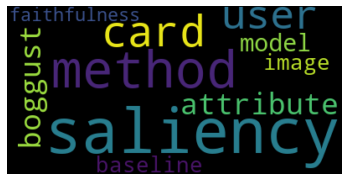

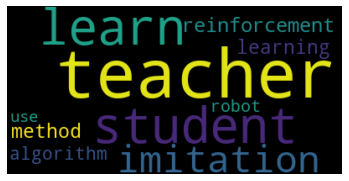

In [203]:
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

lem_strings = [" ".join(l) for l in lemmatized_documents[0:10]]
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(lem_strings)


df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(df)

for i, row in df.iterrows():
    wordcloud = WordCloud(max_words=10).generate_from_frequencies(row)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()



### Sentiment analysis using LLM. Code is used from medium article linked in line 1. Further analysis in progress.

In [204]:
#https://medium.com/data-and-beyond/sentiment-analysis-with-chatgpt-openai-and-python-use-chatgpt-to-build-a-sentiment-analysis-ai-2b89158a37f6
# Use this code block if you ONLY want to know the sentiment for each review. This code will NOT try to summarize each review.
import pandas as pd
import requests
from tqdm import tqdm
import time

# Create a custom function that will call the openAI API and send your reviews data to it one review at a time
# We will use the tqdm library to create a progress tracker so we can see if there are any problems with the openAI API processing our requests
def analyze_my_texts(txt):
    retries = 10
    sentiment = None

    while retries > 0:
        messages = [
            {"role": "system", "content": "You are an AI language model trained to analyze and detect the sentiment of news articles from MIT on the topic of artificial inteligence."},
            {"role": "user", "content": f"Analyze the following product review and determine if the sentiment is: positive, negative or neutral. Return only a single word, either POSITIVE, NEGATIVE or NEUTRAL: {txt}"}
        ]

        completion = openai.ChatCompletion.create(
            model="gpt-3.5-turbo",
            messages=messages,
            # We only want a single word sentiment determination so we limit the results to 3 openAI tokens, which is about 1 word. 
            # If you set a higher max_tokens amount, openAI will generate a bunch of additional text for each response, which is not what we want it to do
            max_tokens=3,
            n=1,
            stop=None,
            temperature=0
        )

        response_text = completion.choices[0].message.content
        # print the sentiment for each customer review, not necessary but it's nice to see the API doing something :)
        print(response_text)

        # Sometimes, the API will be overwhelmed or just buggy so we need to check if the response from the API was an error message or one of our allowed sentiment classifications.
        # If the API returns something other than POSITIVE, NEGATIVE or NEUTRAL, we will retry that particular review that had a problem up to 3 times. This is usually enough.
        if response_text in ["POSITIVE", "NEGATIVE", "NEUTRAL"]:
            sentiment = response_text
            break
        else:
            retries -= 1
            time.sleep(30)
    else:
        sentiment = "neutral"

    retries = 10
   
    # OpenAI will limit the number of times you can access their API if you have a free account. 
    # If you are using the openAI free tier, you need to add a delay of a few seconds (i.e. 4 seconds) between API requests to avoid hitting the openai free tier API call rate limit.
    # This code will still work with an openAI free tier account but you should limit the number of reviews you want to analyze (<100 at a time) to avoid running into random API problems.

    time.sleep(30)

    return sentiment


In [ ]:
import numpy as np
df = articles

# Analyze each review using ChatGPT and save the results in a list called sentiments so we can access the results later
sentiments = []  

# Here we loop through all of the reviews in our dataset and send them to the openAI API using our custom function from above
for batch in np.arange(0,1004,10):
    print(batch)
    for review in tqdm(df["Text"], desc="Processing reviews"):
        time.sleep(30)
        sentiment = analyze_my_review(review)
        sentiments.append(sentiment)

# Now let's save the openAI API results as an additional column in our original dataset
df["sentiment"] = sentiments
